In [14]:
import pandas as pd
df=pd.read_csv("/content/exchange_rate.csv")
df.set_index('date',inplace=True)
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [15]:
df.columns

Index(['Ex_rate'], dtype='object')

2. Initial Exploration

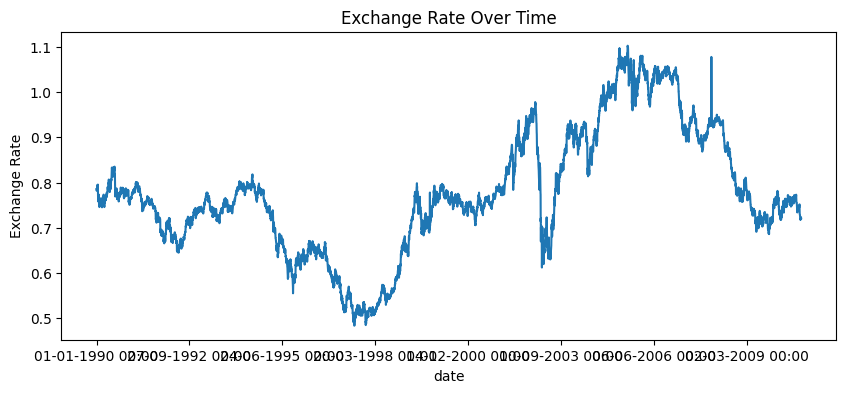

In [16]:
import matplotlib.pyplot as plt

# Plot time series for Ex_rate
df['Ex_rate'].plot(title='Exchange Rate Over Time', figsize=(10,4))
plt.ylabel('Exchange Rate')
plt.show()

3. Data Preprocessing


In [17]:
df['Ex_rate'] = df['Ex_rate'].interpolate(method='linear')

Part 2: Model Building - ARIMA

1. Parameter Selection Using ACF/PACF

CF (Autocorrelation): Suggests values for q (MA order).

PACF (Partial Autocorrelation): Suggests values for p (AR order).

d is typically 1 if the series is not stationary (detected via .diff() and plotting, or by running Augmented Dickey-Fuller test).


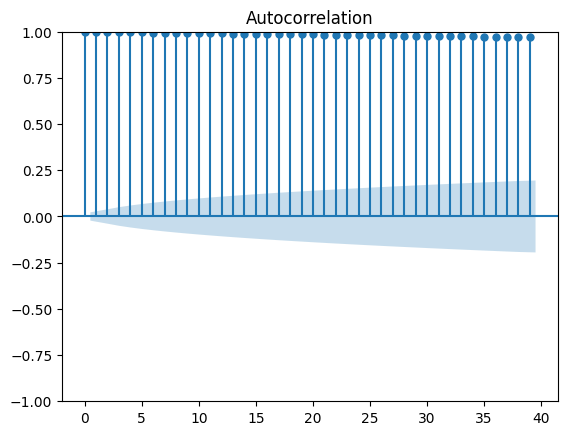

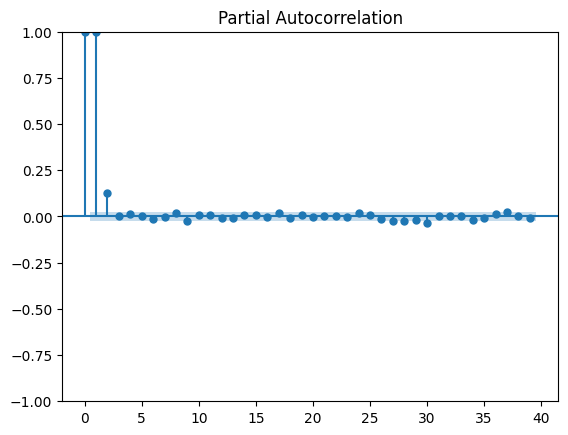

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Ex_rate'])
plot_pacf(df['Ex_rate'])
plt.show()


2. Model Fitting
python

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Example parameters: p=1, d=1, q=1 (use ACF/PACF to determine)
model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_fit = model.fit()
print(arima_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 18 Aug 2025   AIC                         -56102.322
Time:                        07:17:46   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

3. Diagnostics

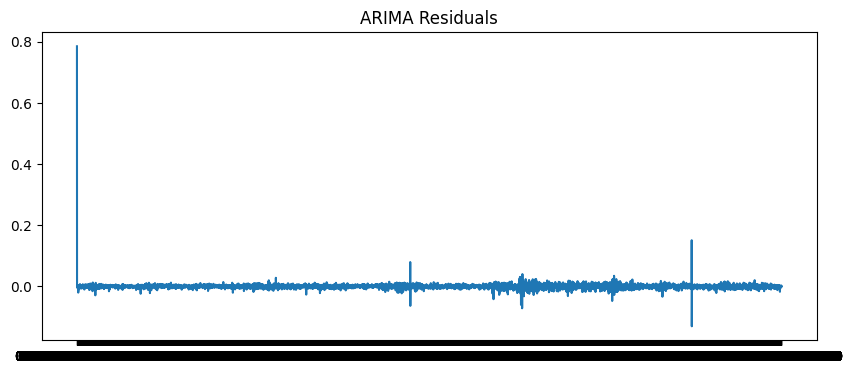

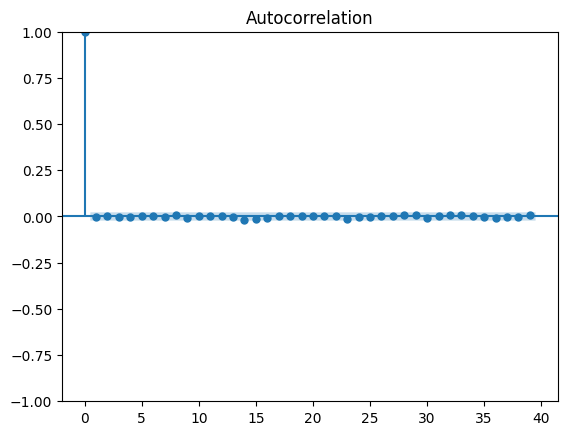

In [20]:
residuals = arima_fit.resid
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('ARIMA Residuals')
plt.show()

# Check autocorrelation of residuals (should be random)
plot_acf(residuals.dropna())
plt.show()


Explanation:

Residuals should resemble white noise (no autocorrelation or patterns).

4. Forecasting


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


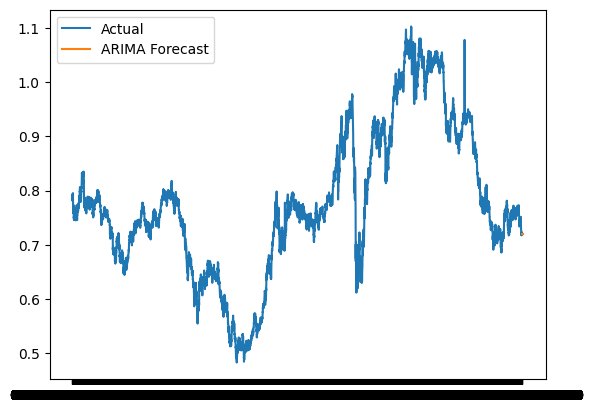

In [21]:
forecast = arima_fit.forecast(steps=20)  # Next 20 periods
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

Part 3: Model Building - Exponential Smoothing


Simple Exponential Smoothing: If no trend/seasonality.

Holt’s Linear: If there’s a trend.

Holt-Winters: If there’s seasonality (not common in daily FX rates, more in monthly rates).

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Example: Holt’s Linear Trend Model
model_holt = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
holt_fit = model_holt.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


2. Parameter Optimization

In [24]:
# Statsmodels automatically optimizes parameters, but you can specify values or grid-search over smoothing parameters if needed.
print(holt_fit.params)


{'smoothing_level': np.float64(0.8698402860748511), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(0.7851093972242965), 'initial_trend': np.float64(-8.473596416712384e-06), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


3. Model Fitting and Forecasting

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


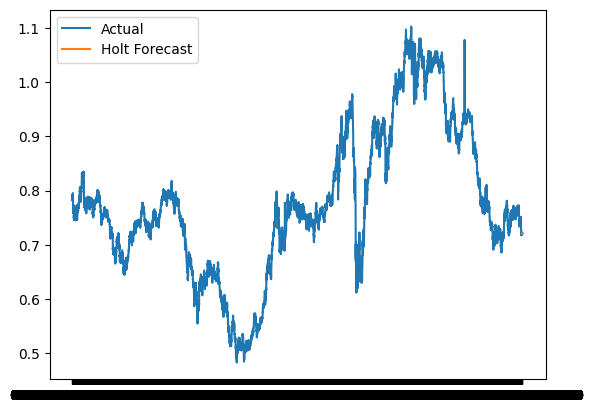

In [25]:
holt_forecast = holt_fit.forecast(steps=20)
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(holt_forecast.index, holt_forecast, label='Holt Forecast')
plt.legend()
plt.show()

Part 4: Evaluation and Comparison

1. Compute Error Metrics
python

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate evaluation metrics for ARIMA
# Use the original data for comparison as no separate test set is available
mae_arima = mean_absolute_error(df['Ex_rate'], arima_fit.fittedvalues)
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'], arima_fit.fittedvalues))
# Calculate MAPE manually to handle potential division by zero with the original data
mape_arima = np.mean(np.abs((df['Ex_rate'] - arima_fit.fittedvalues) / df['Ex_rate'])) * 100

# Calculate evaluation metrics for Holt's Linear model
# Use the original data for comparison as no separate test set is available
mae_holt = mean_absolute_error(df['Ex_rate'], holt_fit.fittedvalues)
rmse_holt = np.sqrt(mean_squared_error(df['Ex_rate'], holt_fit.fittedvalues))
# Calculate MAPE manually to handle potential division by zero with the original data
mape_holt = np.mean(np.abs((df['Ex_rate'] - holt_fit.fittedvalues) / df['Ex_rate'])) * 100

print(f"ARIMA Metrics:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.4f}%")
print("\nHolt Metrics:")
print(f"MAE: {mae_holt:.4f}")
print(f"RMSE: {rmse_holt:.4f}")
print(f"MAPE: {mape_holt:.4f}%")

ARIMA Metrics:
MAE: 0.0038
RMSE: 0.0108
MAPE: 0.4951%

Holt Metrics:
MAE: 0.0037
RMSE: 0.0060
MAPE: 0.4820%


2. Model Comparison
ARIMA:

Captures autocorrelation and trends well.

Best for stationary series or those made stationary by differencing.

Exponential Smoothing (Holt/Holt-Winters):

Flexible for trends/seasonality.

Often smoother, less sensitive to abrupt changes.

Visual Comparison: Overlay actual and forecast lines; use bar charts for error metrics.

3. Conclusion
Summarize which model performed best (lowest MAE, RMSE, and MAPE).

Discuss possible improvements (hyperparameter tuning, adding exogenous variables, etc.).

Insights: E.g., ARIMA may better handle complex autocorrelation; Holt’s method excels for strong trends. Model selection should reflect the data’s underlying structure.





